# Template for HW4
Use this file as a template. In your submission, save any computation results and outputs and submit the file, so we can see it when we grade.

You'll be using the tutorial at https://medium.com/data-science-in-your-pocket/modernbert-for-text-classification-04d7fba42dae as a starting point.
Then you'll modify it so that it uses the dataset "sentence-transformers/all-nli" instead. You'll need to really understand how the code works to do this: look up the documentation for the individual functions. Read about the dataset and find out its structure.

In [ ]:
%pip install "torch==2.5.0" "torchvision==0.20.0"
%pip install "setuptools<71.0.0" scikit-learn

%pip install  --upgrade \
  "datasets==3.1.0" \
  "accelerate==1.2.1" \
  "hf-transfer==0.1.8"

%pip install "git+https://github.com/huggingface/transformers.git@6e0515e99c39444caae39472ee1b2fd76ece32f1" --upgrade

  Using cached datasets-3.1.0-py3-none-any.whl.metadata (20 kB)
  Using cached accelerate-1.2.1-py3-none-any.whl.metadata (19 kB)
  Using cached hf_transfer-0.1.8-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.7 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached xxhash-3.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2024.9.0-py3-none-any.whl.metadata (11 kB)
Using cached datasets-3.1.0-py3-none-any.whl (480 kB)
Using cached accelerate-1.2.1-py3-none-any.whl (336 kB)
Using cached hf_transfer-0.1.8-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
Using cached dill-0.3.8-py3-none-any.whl (116 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:

#load modernbert (base) and your dataset here. Follow the tutorial (with any necessary modifications) at: https://medium.com/data-science-in-your-pocket/modernbert-for-text-classification-04d7fba42dae
from datasets import load_dataset
from datasets.arrow_dataset import Dataset
from datasets.dataset_dict import DatasetDict, IterableDatasetDict
from datasets.iterable_dataset import IterableDataset
import numpy as np

# Dataset id from huggingface.co/dataset
# dataset_id = "argilla/synthetic-domain-text-classification"
dataset_id = "sentence-transformers/all-nli"

# Load raw dataset
# train_dataset = load_dataset(dataset_id, split='train')
train_dataset = load_dataset(dataset_id, 'pair-class', split='train[:3%]')
#divide train set into fraction of the size, so more computationally feasible


split_dataset = train_dataset.train_test_split(test_size=0.1)
# print(split_dataset['train'][5:7])
print(split_dataset)

# create a new column in split_dataset which concatenates the "premise" and "hypothesis" columns
split_dataset = split_dataset.map(lambda x: {"text": x["premise"] + " <s> " + x["hypothesis"]}, remove_columns=["premise", "hypothesis"])
# print(split_dataset['train'][5:7])
# print(split_dataset)

from transformers import AutoTokenizer

# Model id to load the tokenizer
model_id = "answerdotai/ModernBERT-base"

# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Tokenize helper function
def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding="max_length", return_tensors="pt", max_length=500)#tokenizer.model_max_length)


# Tokenize dataset
if "label" in split_dataset["train"].features.keys():
    split_dataset =  split_dataset.rename_column("label", "labels") # to match Trainer
tokenized_dataset = split_dataset.map(tokenize, batched=True, remove_columns=["text"])

from transformers import AutoModelForSequenceClassification

# Model id to load the tokenizer
model_id = "answerdotai/ModernBERT-base"

# Prepare model labels - useful for inference
labels = tokenized_dataset["train"].features["labels"].names
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

# Download the model from huggingface.co/models
model = AutoModelForSequenceClassification.from_pretrained(
    model_id, num_labels=num_labels, label2id=label2id, id2label=id2label,
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train-00000-of-00001.parquet:   0%|          | 0.00/69.5M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


dev-00000-of-00001.parquet:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


test-00000-of-00001.parquet:   0%|          | 0.00/1.61M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/942069 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/19657 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/19656 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 25435
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 2827
    })
})


Map:   0%|          | 0/25435 [00:00<?, ? examples/s]

Map:   0%|          | 0/2827 [00:00<?, ? examples/s]

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Map:   0%|          | 0/25435 [00:00<?, ? examples/s]

Map:   0%|          | 0/2827 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# train your model here, using fine-tuning. Print out training data and save it as part of this notebook file. Again follow the tutorial (with any necessary modifications) at: https://medium.com/data-science-in-your-pocket/modernbert-for-text-classification-04d7fba42dae

from transformers import Trainer, TrainingArguments

# Define training args
training_args = TrainingArguments(
    output_dir= "ModernBERT-domain-classifier",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=2,
    learning_rate=5e-5,
    num_train_epochs=2,
    bf16=True, # bfloat16 training
    optim="adamw_torch_fused", # improved optimizer
    # logging & evaluation strategies
    logging_strategy="steps",
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_total_limit=2,
    load_best_model_at_end=True,
)

# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"] #note that we're using the test set as the validation set here---normally a no-no!
)
trainer.train()

Step,Training Loss,Validation Loss
500,0.999700,0.814199
1000,0.776600,0.830991
1500,0.683300,0.709370
2000,0.656400,0.843120
2500,0.648600,0.791197
3000,0.655400,0.616892
3500,0.645400,0.528159
4000,0.599900,0.722736
4500,0.590000,0.592713
5000,0.577700,0.616786


Step,Training Loss,Validation Loss
500,0.999700,0.814199
1000,0.776600,0.830991
1500,0.683300,0.709370
2000,0.656400,0.843120
2500,0.648600,0.791197
3000,0.655400,0.616892
3500,0.645400,0.528159
4000,0.599900,0.722736
4500,0.590000,0.592713
5000,0.577700,0.616786


TrainOutput(global_step=12718, training_loss=0.5106399813281757, metrics={'train_runtime': 14817.8555, 'train_samples_per_second': 3.433, 'train_steps_per_second': 0.858, 'total_flos': 1.692819511767e+16, 'train_loss': 0.5106399813281757, 'epoch': 2.0})

In [16]:
# Save the model and tokenizer
from transformers import Trainer, TrainingArguments
# Define training args
training_args = TrainingArguments(
    output_dir= "ModernBERT-domain-classifier",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=2,
    learning_rate=5e-5,
    num_train_epochs=2,
    bf16=True, # bfloat16 training
    optim="adamw_torch_fused", # improved optimizer
    # logging & evaluation strategies
    logging_strategy="steps",
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_total_limit=2,
    load_best_model_at_end=True,
)

# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"] #note that we're using the test set as the validation set here---normally a no-no!
)
trainer.save_model("ModernBERT-domain-classifier")
tokenizer.save_pretrained("ModernBERT-domain-classifier")

('ModernBERT-domain-classifier/tokenizer_config.json',
 'ModernBERT-domain-classifier/special_tokens_map.json',
 'ModernBERT-domain-classifier/tokenizer.json')

In [17]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load trained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("ModernBERT-domain-classifier")
model = AutoModelForSequenceClassification.from_pretrained("ModernBERT-domain-classifier")

from transformers import Trainer, TrainingArguments

# Define training args
training_args = TrainingArguments(
    output_dir= "ModernBERT-domain-classifier",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=2,
    learning_rate=5e-5,
    num_train_epochs=2,
    bf16=True, # bfloat16 training
    optim="adamw_torch_fused", # improved optimizer
    # logging & evaluation strategies
    logging_strategy="steps",
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_total_limit=2,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=tokenized_dataset["test"]
)

In [20]:
import numpy as np

# test your trained model on the test set here. Report statistics and save the test data as part of this notebook file.
predictions = trainer.predict(tokenized_dataset["test"])

# Process the prediction results (predictions, label_ids, metrics)
predicted_labels = np.argmax(predictions.predictions, axis=1)
predicted_label = id2label[str(predicted_labels[0])]


example_data = [split_dataset['train'][0]]
print("Example Input:", example_data[0]['text'])
print(f"Predicted Label: {predicted_label}")
print(f"Actual Label: {id2label[str(example_data[0]['labels'])]}")



Example Input: A band made up of a guitarist, bass guitarist, drummer, and female vocalist performs at a well lit venue. <s> a band preforming at a big concert
Predicted Label: neutral
Actual Label: neutral


### Question 1
Analyze the true positive / false positive / true negative / false negative rates overall, treating every answer as either wrong or right (e.g., if the correct answer was 0, then only 0 is correct and 1 or 2 are both wrong). What results do you get? What does this tell you?

-------

**answer this question here. Add additional code blocks to show your work and/or display figures/charts.**

Based solely on accuracy of predicting only right or wrong of the hypothesis given the premise, the model has a accuracy success of roughly 82%. I believe this is a fair accuracy value given that the model was trained given the set parameters. The number of times the entire training dataset was passed through the model was set to 2 (num_train_epochs=2). By further fine tuning this parameters like this one, I could possibly get the model to obtain a higher accuracy level which can be explored in future personal explorations.

While this is still a good prediction performance, the fraction of incorrect predictions may suggests that the model is still making a significant number of mistakes. Since this evaluation treats all wrong predictions the same, we cannot uncover whether the model struggles more with certain types of inputs or categories. If the accuracy was too high, for example above 95%, that may indicate that the model was overtrained and began to overfit based on the training set.

Question 1 Results
Correct Predictions: 2308
Incorrect Predictions: 519
Accuracy: 81.64%



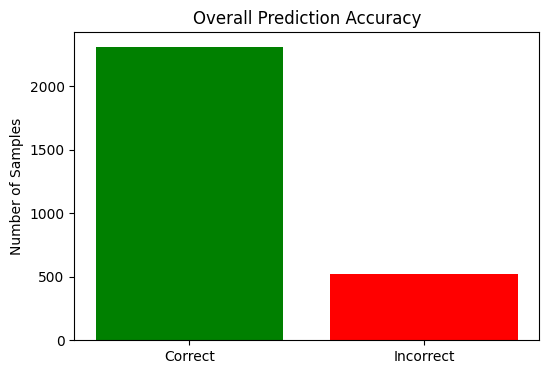

In [21]:
# any code used to answer Question 2 goes here

import matplotlib.pyplot as plt
# get and store predictions
true_labels = predictions.label_ids
TP_TN = np.sum(predicted_labels == true_labels)   # right predictions
FP_FN = np.sum(predicted_labels != true_labels)  # wrong predictions
accuracy = TP_TN / (TP_TN + FP_FN) * 100
#  no actual "true negative" being tracked will explain in analysis.
print("Question 1 Results")
print(f"Correct Predictions: {TP_TN}")
print(f"Incorrect Predictions: {FP_FN}")
print(f"Accuracy: {accuracy:.2f}%")
print()
# plot bar chart
plt.figure(figsize=(6, 4))
plt.bar(['Correct', 'Incorrect'], [TP_TN, FP_FN], color=['green', 'red'])
plt.title("Overall Prediction Accuracy")
plt.ylabel("Number of Samples")
plt.savefig("question1_plot.png")
plt.show()



### Question 2
Now analyze the TP/FP/TN/FN rates *for each category* (contradiction, entailment, neutral). What do you learn? What does this tell you that you couldn't tell from the answer to Question 1?

-------

**answer this question here. Add additional code blocks to show your work and/or display figures/charts.**

Given that 0 indicates entailment, 1 indicates neutral, and 2 indicates contradiction we can further analyse the accuracy of the model. We can breakdown prediction attempts into categories of true positives, false positives, true negatives, and false negatives which tells us that the model performs reasonably well overall but struggles mostly with neutral cases. Both entailment and contradiction classes had strong true positive counts (834 and 743, respectively) and relatively lower false negatives compared to neutral, which had the weakest performance with the lowest true positives (731) and highest false negatives (207). This may indicate that the model struggles in detecting subtle or context-dependent relationships that define neutral examples, as opposed to the clearer patterns found in entailment and contradiction.

Including the true negatives helps reveal that the model is generally good at ruling out incorrect classes, especially for contradiction, which had the lowest false positive count (82). The neutral class, however, not only had high false negatives but also a high number of false positives (220), indicating that it’s the most confusing class for the model to predict. This extra depth of analysis highlights where the model is overconfident (such as mistaking neutral for entailment) and where it is too conservative. These insights could not be made by looking at only the raw accuracy in Question 1.




Question 2 Results

Class 0: Entailment
  True Positive: 834
  False Positive: 217
  True Negative: 1677
  False Negative: 99

Class 1: Neutral
  True Positive: 731
  False Positive: 220
  True Negative: 1669
  False Negative: 207

Class 2: Contradiction
  True Positive: 743
  False Positive: 82
  True Negative: 1789
  False Negative: 213



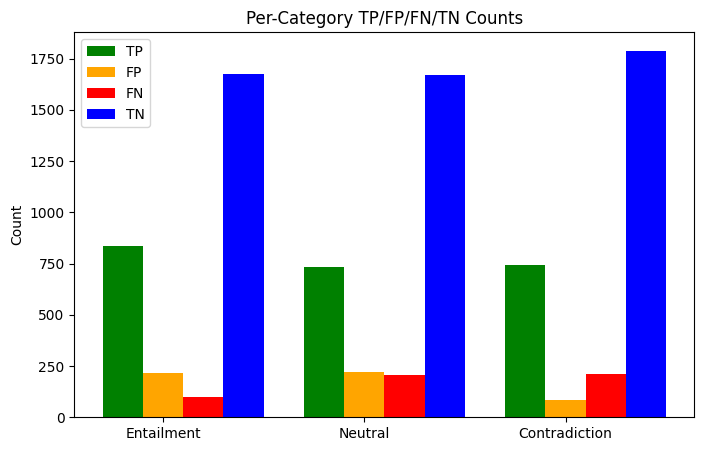

In [23]:
# any code used to answer Question 2 goes here

# given that labelid2 = {'0': 'entailment', '1': 'neutral', '2': 'contradiction'}
classes = np.unique(true_labels) # get unique classes of labels in dataset
results = {} # store TP, FP, TN, FN for each class

for c in classes: # iterate over labels and get sum of TP, FP, TN, FN
    TP = np.sum((predicted_labels == c) & (true_labels == c))
    FP = np.sum((predicted_labels == c) & (true_labels != c))
    TN = np.sum((predicted_labels != c) & (true_labels != c))
    FN = np.sum((predicted_labels != c) & (true_labels == c))
    results[c] = {"TP": TP, "FP": FP, "TN": TN, "FN": FN} # store results

print("Question 2 Results")
for c in classes: # print results
    label_name = ['Entailment', 'Neutral', 'Contradiction'][c]
    print(f"\nClass {c}: {label_name}")
    print(f"  True Positive: {results[c]['TP']}")
    print(f"  False Positive: {results[c]['FP']}")
    print(f"  True Negative: {results[c]['TN']}")
    print(f"  False Negative: {results[c]['FN']}")

print("")
# plot graph
plt.figure(figsize=(8, 5))
labels = ['Entailment', 'Neutral', 'Contradiction']
TP_values = [results[c]['TP'] for c in classes]
FP_values = [results[c]['FP'] for c in classes]
FN_values = [results[c]['FN'] for c in classes]
TN_values = [results[c]['TN'] for c in classes]

x = np.arange(len(labels))
plt.bar(x - 0.2, TP_values, width=0.2, label='TP', color='green')
plt.bar(x, FP_values, width=0.2, label='FP', color='orange')
plt.bar(x + 0.2, FN_values, width=0.2, label='FN', color='red')
plt.bar(x + 0.4, TN_values, width=0.2, label='TN', color='blue')
plt.xticks(x, labels)
plt.ylabel("Count")
plt.title("Per-Category TP/FP/FN/TN Counts")
plt.legend()
plt.savefig("question2_plot.png")
plt.show()


### Question 3
Analyze specific errors. For example, look at questions that had (x) as a correct answer but the model guessed (y) instead. Look at specific cases. What do you notice? Come up with at least 4 hypotheses about what kinds of problems it's getting right and wrong.

-------

**answer this question here. Add additional code blocks to show your work and/or display figures/charts.**

The three most frequent prediction inaccuracies involved the neutral class, with the model either mistaking neutral labels for entailment or contradiction  and entailment examples for nuetral. This suggests that the model struggled most with recognizing statements that are unrelated or weakly related, especially if features like shared words make the connection appear stronger than it really is.

These errors implied that the model has trouble distinguishing whether two sentences are truly logically unrelated versus being implicitly related (entailment) or logically contradicting.

Four hypotheses of why the model has these problems are:
1. Many misclassifications (between nuetral and entailment) happen especially when sentences share similar words but differ subtly in meaning or context.
2. Short premises or hypotheses provide fewer context clues, which encourages the model to guess based on weak signals like word overlap rather than the actual meaning of the sentence.
3. Model may misinterpret double negatives or subtle negations and treat the sentence without using the intended meaning.
4. Overconfident prediction in entailment when word overlap is high, even if the logic is weak.

In [25]:
# any code used to answer Question 3 goes here

from collections import Counter
import random
# map label IDs to their names for better readability
label_names = {0: 'Entailment', 1: 'Neutral', 2: 'Contradiction'}

# pair true labels with predicted labels
pair_counts = Counter(zip(true_labels, predicted_labels))

print("Question 3 Results")
print("Most frequent pairs (True -> Predicted):\n")

# print top 9 most common error patterns
top_pairs = pair_counts.most_common(9)
for pair, count in top_pairs:
    print(f"True Label: {label_names[pair[0]]} ({pair[0]}) -> Predicted: {label_names[pair[1]]} ({pair[1]}) | Count: {count}")


Question 3 Results
Most frequent pairs (True -> Predicted):

True Label: Entailment (0) -> Predicted: Entailment (0) | Count: 834
True Label: Contradiction (2) -> Predicted: Contradiction (2) | Count: 743
True Label: Neutral (1) -> Predicted: Neutral (1) | Count: 731
True Label: Neutral (1) -> Predicted: Entailment (0) | Count: 143
True Label: Contradiction (2) -> Predicted: Neutral (1) | Count: 139
True Label: Entailment (0) -> Predicted: Neutral (1) | Count: 81
True Label: Contradiction (2) -> Predicted: Entailment (0) | Count: 74
True Label: Neutral (1) -> Predicted: Contradiction (2) | Count: 64
True Label: Entailment (0) -> Predicted: Contradiction (2) | Count: 18


### Question 4

Given your hypotheses from question 3, create a few test cases manually and see if they confirm or refute your hypotheses.

-------

**answer this question here. Add additional code blocks to show your work and/or display figures/charts.**

I used two examples to test my hypotheses from the third question. Based on the predicted results, all my hypotheses have been proved coreect as for each of them, the trained model did not accurately predict at least one case example. We can deduct that it is difficult under certain circumstances for the model to truly differentiate nuetral sentences from both entailmemt and contradiction. For the first hypothesis, the model correctly identified the first neutral example but misclassified the second as entailment, confirming it struggles to detect subtle context shifts when sentences share certain context/logical similarity but are not exactly the same by definition. By hypothesis 2, shorter sentences give less information for the model to make its prediction off, so it may lead to a wrong prediction. 

The third hypothesis also showed that the model struggles with complex negation as both negation examples were misclassified. Finally, the last hypothesis also proved that cases of high word overlap appeared to confuse the model, leading to mislabeling the last example ("The bat is drinking from a cup") as entailment rather than neutral.

These targeted tests reinforce the idea that the model, although performing well on clear cases, often fails when context interpretation, negation, or subtle semantic distinctions are involved. To address this, additional training with an additional/supplemental dataset, or further fine-tuning of the learning parameters, might improve its ability to handle such borderline cases.

In [34]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# load trained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("ModernBERT-domain-classifier")
model = AutoModelForSequenceClassification.from_pretrained("ModernBERT-domain-classifier")

# define test cases with expected labels
# Label mapping: 0 = Entailment, 1 = Neutral, 2 = Contradiction
# two examples for each hypotheses
test_examples = [
    # hypothesis 1 - share similar words but subtle differnces in context
    {"premise": "A group of people is sitting at a table", "hypothesis": "People are having a meeting", "expected": 1},               # Neutral case
    {"premise": "Two friends are walking in the park", "hypothesis": "Two people are outside together", "expected": 1},               # Neutral case

    # hypothesis 2 - short premise/label can lead to guessing
    {"premise": "The sky is blue", "hypothesis": "The sky is dull", "expected": 2},                                                   # Contradiction case
    {"premise": "Mary has a car", "hypothesis": "Mary can drive", "expected": 0},                                                     # Entailment case

    # hypothesis 3 - cannot understand double negatives or inconvenient negatives
    {"premise": "The man did not finish the race", "hypothesis": "The man completed the race", "expected": 2},                        # Contradiction case
    {"premise": "She never eats meat but sometimes eats seafood", "hypothesis": "She is not vegan but a pescatarian", "expected": 0}, # Entailment case

    # hypothesis 4 - when word overlap is high then the model may predict entailment
    {"premise": "A dog is sleeping next to a brown ball", "hypothesis": "A brown dog is playing with a ball", "expected": 2},            # contradiction case
    {"premise": "The guy is holding a bat and drinking from his cup", "hypothesis": "The bat is drinking from a cup", "expected": 1}     # neutral case
]

# tokenize the new examples
encoded_inputs = tokenizer(
    [ex["premise"] for ex in test_examples],
    [ex["hypothesis"] for ex in test_examples],
    padding=True,
    truncation=True,
    return_tensors="pt"
)

# move tensors to model device
encoded_inputs = {key: val.to(model.device) for key, val in encoded_inputs.items()}

# run inferences
with torch.no_grad():
    outputs = model(**encoded_inputs)
    logits = outputs.logits
    predicted_labels = np.argmax(logits.cpu().numpy(), axis=1)

# output predictions
for i, example in enumerate(test_examples):
    predicted_label = id2label[str(predicted_labels[i])]
    actual_label = id2label[str(example["expected"])]
    print("Example Input:", f"Premise: {example['premise']} | Hypothesis: {example['hypothesis']}")
    print(f"Predicted Label: {predicted_label}")
    print(f"Actual Label: {actual_label}\n")



Example Input: Premise: A group of people is sitting at a table | Hypothesis: People are having a meeting
Predicted Label: neutral
Actual Label: neutral

Example Input: Premise: Two friends are walking in the park | Hypothesis: Two people are outside together
Predicted Label: entailment
Actual Label: neutral

Example Input: Premise: The sky is blue | Hypothesis: The sky is dull
Predicted Label: neutral
Actual Label: contradiction

Example Input: Premise: Mary has a car | Hypothesis: Mary can drive
Predicted Label: neutral
Actual Label: entailment

Example Input: Premise: The man did not finish the race | Hypothesis: The man completed the race
Predicted Label: neutral
Actual Label: contradiction

Example Input: Premise: She never eats meat but sometimes eats seafood | Hypothesis: She is not vegan but a pescatarian
Predicted Label: contradiction
Actual Label: entailment

Example Input: Premise: A dog is sleeping next to a brown ball | Hypothesis: A brown dog is playing with a ball
Predic